# БеспощадныйДробитель трека на промежуточные точки

### Инициализация

In [5]:
import datetime as dt

# pip install numpy
import numpy as np

# pip install scipy
from scipy import interpolate

# pip install matplotlib
import matplotlib.pyplot as plt

# pip install GPX
from gpx import GPX  # https://gpx.readthedocs.io/en/latest/
from gpx import Track
from gpx import TrackSegment
from gpx import Waypoint

plt.style.use('dark_background')   # Чёрная тема

### Общие параметры

In [6]:
# Путь к исходному файлу
# trek_file_path = 'CОбх.gpx'
trek_file_path = 'Через два моста.gpx'

# Расстояние между промежуточными точками
distance_between_points = 50.0 # метров

## Работа с треком

### Загрузка трека

Число сегментов:	1
Число точек в треке:	59
Длина трека:		6722.55 m


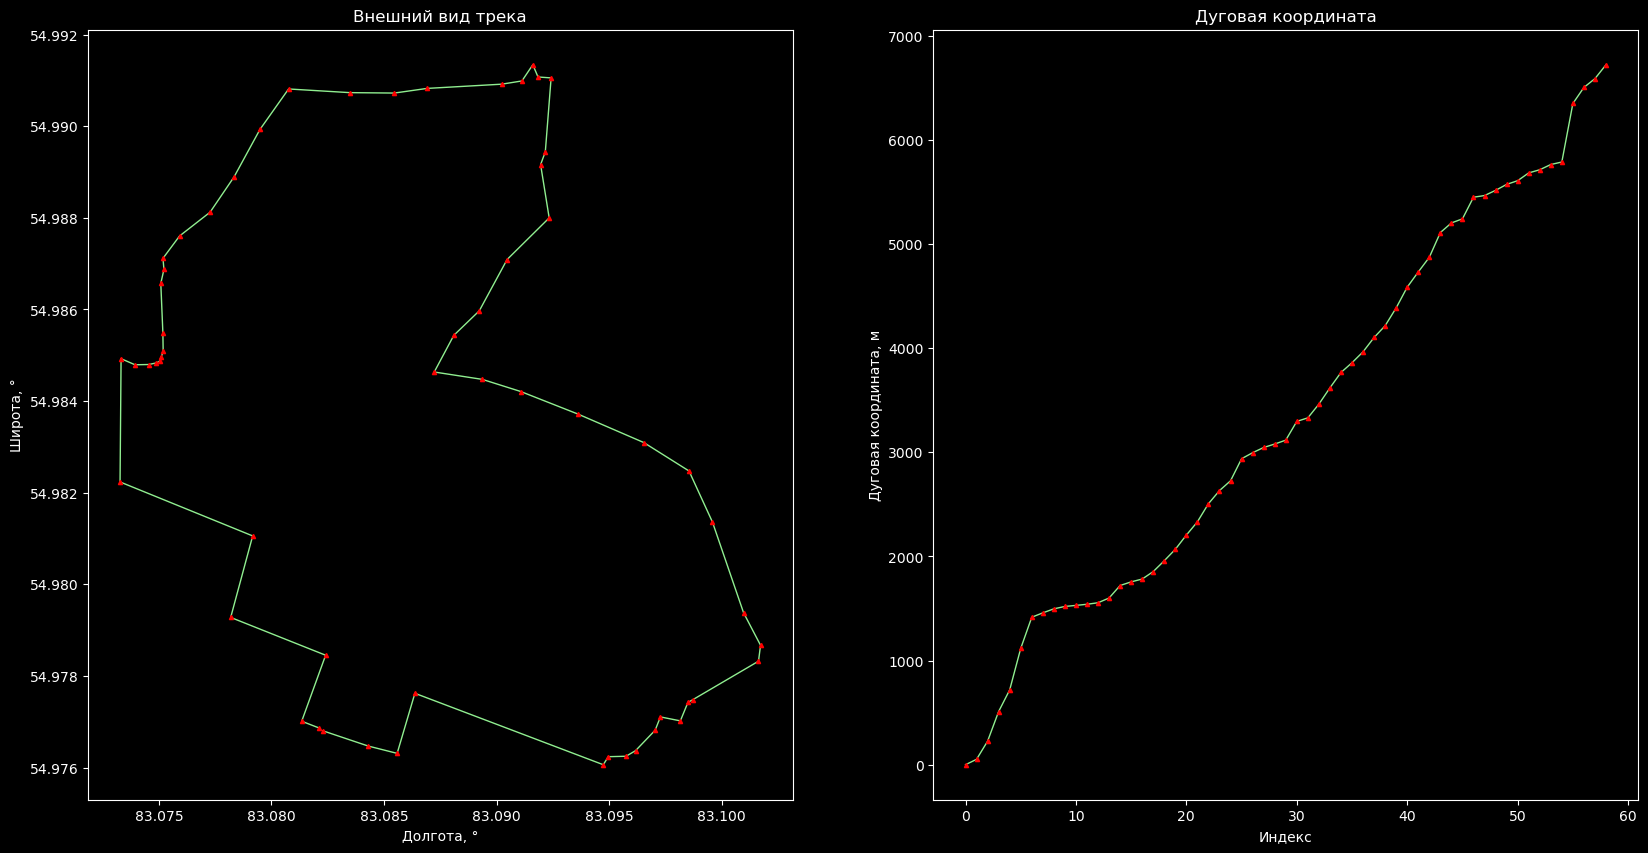

In [11]:
gpx = GPX.from_file(trek_file_path)

track_points = np.concatenate(gpx.tracks[0].segments)   # Объеденные сегменты, если они были разъеденные
track_length = gpx.tracks[0].distance

print(f'Число сегментов:\t{len(gpx.tracks[0].segments)}')
print(f'Число точек в треке:\t{len(track_points)}')
print(f'Длина трека:\t\t{track_length} m')


# Соотношение строн для графиков в от жЫрноты
offset_point_lat = Waypoint()
offset_point_lat.lon = track_points[0].lon
offset_point_lat.lat = float(track_points[0].lat) + 1.0

offset_point_lon = Waypoint()
offset_point_lon.lon = float(track_points[0].lon) + 1.0
offset_point_lon.lat = track_points[0].lat

plot_aspect_ration = track_points[0].distance_to(offset_point_lat) / track_points[0].distance_to(offset_point_lon) 


arc_coordinates_orig = [0.0] 
lats_orig = [track_points[0].lat]
lons_orig = [track_points[0].lon]


for n in range(1, len(track_points)):
    dist = track_points[n].distance_to(track_points[n - 1])
    
    arc_coordinates_orig.append(arc_coordinates_orig[n - 1] + dist)
    lats_orig.append(track_points[n].lat)
    lons_orig.append(track_points[n].lon)
    
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))

ax1.plot(lons_orig, lats_orig, marker='^', mfc='r', mec='r', ms=3, c='lightgreen', lw=1)
ax1.set_title('Внешний вид трека')
ax1.set_xlabel('Долгота, °')
ax1.set_ylabel('Широта, °')

ax2.plot(range(len(track_points)), arc_coordinates_orig, marker='^', mfc='r', mec='r', ms=3, c='lightgreen', lw=1)
ax2.set_title('Дуговая координата')
ax2.set_xlabel('Индекс')
ax2.set_ylabel('Дуговая координата, м')

plt.show()

### Получение новых промежуточных точек интерполяцией по дуговой координате

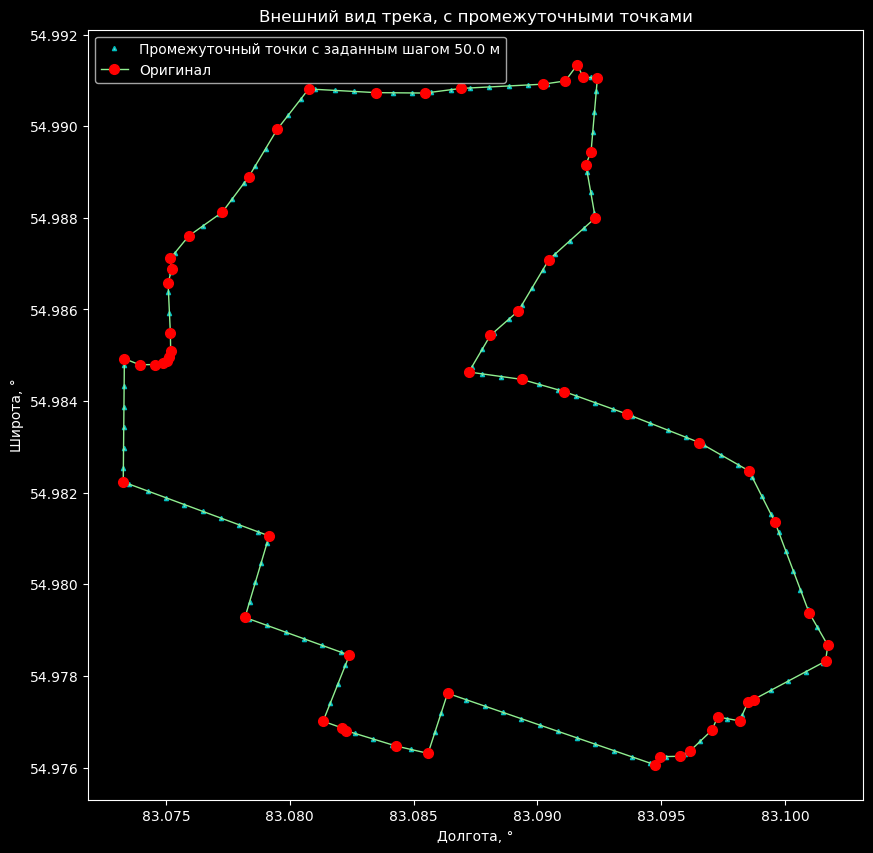

In [10]:
# Функции линейной интерполяции
lat_interp_func = interpolate.interp1d(arc_coordinates_orig, [float(i) for i in lats_orig])
lon_interp_func = interpolate.interp1d(arc_coordinates_orig, [float(i) for i in lons_orig])

# Промежуточные точки
arc_coordinates_new = np.arange(0.0, track_length, distance_between_points)
lats_new = lat_interp_func(arc_coordinates_new)
lons_new = lon_interp_func(arc_coordinates_new)

fig, ax = plt.subplots(1, 1, figsize = (10, 10))

ax.plot(lons_new, lats_new, marker='^', mec='c', ms=3, lw=0, label=f'Промежуточный точки с заданным шагом {distance_between_points} м')
ax.plot(lons_orig, lats_orig, marker='o', mfc='r', mec='r', ms=7, ls='-', c='lightgreen', lw=1, label='Оригинал')
ax.set_title('Внешний вид трека, с промежуточными точками')
ax.set_xlabel('Долгота, °')
ax.set_ylabel('Широта, °')

plt.legend()
plt.show()

### Экспорт результатов

- Старые точки трека уходят в контейнер ```<wpt>```
- Новые точки сохраняются в контейнере ```<trk>```, в описание каждой точки добавляется дуговая координата. *Зачем никто не знает, что бы была*
- Новый трек, в общем случае, не будет проходить через старые точки трека, из условия равно удалённость. НО будет отчаянно к этому стремиться
- Новый файл сохраняется рядом со старым, с добавлением постфикса **_divided**


In [9]:
gpx_divided = GPX()
gpx_divided.waypoints = []

# Перекидываем старые точки трека в точки waypoints
counter = 0
for w in track_points:
    w.name = '{:0=3}'.format(counter)
    w.sym = 'Flag, Red'
    gpx_divided.waypoints.append(w)
    counter+=1


# Контейнеры по новые точки трека
track_segment = TrackSegment()
track = Track()
track.name = gpx.tracks[0].name + '_divided'
track.trksegs.append(track_segment)
gpx_divided.tracks.append(track)


datetime_now = dt.datetime.now()  

for n in range(len(arc_coordinates_new)):
    wpt = Waypoint()
    wpt.lat = lats_new[n]
    wpt.lon = lons_new[n]
    wpt.ele = 111.0
    wpt.desc = str(arc_coordinates_new[n])
    wpt.time = datetime_now + dt.timedelta(seconds=n)   # Некоторые проги обижаются если у точки трека нет времени. А если время не растёт! в падают в панику, их можно понять
    
    track_segment.append(wpt)
    

gpx_divided.to_file(trek_file_path.replace('.gpx', '_divided.gpx'))